In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import csv

# Machine Learning

In [2]:
DATA_DIR_2 = '/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv'
machine_learning_data = pd.read_csv(DATA_DIR)

NameError: name 'DATA_DIR' is not defined

In [ ]:
# Convert date columns to datetime where possible
for col in ['INFODT', 'EXAMDT', 'ORIG_ENTRY', 'LAST_UPDATE']:
    if col in machine_learning_data.columns:
        machine_learning_data[col] = pd.to_datetime(machine_learning_data[col], errors='coerce')

# Convert specific date columns
machine_learning_data['EXAMDT'] = pd.to_datetime(machine_learning_data['EXAMDT'], errors='coerce')
machine_learning_data['INFODT'] = pd.to_datetime(machine_learning_data['INFODT'], errors='coerce')

# Fallback: fill missing EXAMDT with INFODT
machine_learning_data['EXAMDT'] = machine_learning_data['EXAMDT'].fillna(machine_learning_data['INFODT'])

# Replace 101 values with NaN in NP3 columns
np3_cols = [col for col in machine_learning_data.columns if col.startswith('NP3') and col != 'NP3TOT']
machine_learning_data[np3_cols] = machine_learning_data[np3_cols].replace(101, np.nan)

#Check outliers or wrong values
np3_cols = [col for col in machine_learning_data.columns if col.startswith('NP3') and col != 'NP3TOT']

# Find out-of-range values
out_of_range = (machine_learning_data[np3_cols] < 0) | (machine_learning_data[np3_cols] > 4)
if out_of_range.any().any():
    print("Warning: Out-of-range NP3 scores detected!")
    display(machine_learning_data.loc[out_of_range.any(axis=1), ['PATNO', 'EXAMDT'] + np3_cols])
else:
    print("All NP3 scores within expected range (0–4). Ignored NP3TOT.")

# Drop rows where NP3TOT is NaN
machine_learning_data = machine_learning_data.dropna(subset=['NP3TOT'])
print(f"Remaining rows after dropping NaN NP3TOT: {len(machine_learning_data)}")


All NP3 scores within expected range (0–4). Ignored NP3TOT.
Remaining rows after dropping NaN NP3TOT: 26109


In [ ]:
motor_features = [
    'PATNO', 'EVENT_ID', 'INFODT',  # Identifying information

    # MDS-UPDRS Part III scores
    'NP3SPCH', 'NP3FACXP',
    'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL',  # Rigidity
    'NP3FTAPR', 'NP3FTAPL',  # Finger tapping
    'NP3HMOVR', 'NP3HMOVL',  # Hand movements
    'NP3PRSPR', 'NP3PRSPL',  # Pronation-supination
    'NP3TTAPR', 'NP3TTAPL',  # Toe tapping
    'NP3LGAGR', 'NP3LGAGL',  # Leg agility
    'NP3RISNG',  # Arising from chair
    'NP3GAIT', 'NP3FRZGT',  # Gait and freezing
    'NP3PSTBL',  # Postural stability
    'NP3POSTR',  # Posture
    'NP3BRADY',  # Body bradykinesia
    'NP3PTRMR', 'NP3PTRML',  # Postural tremor
    'NP3KTRMR', 'NP3KTRML',  # Kinetic tremor
    'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON',  # Rest tremor
    'NP3TOT'  # Total score (needed for target creation)
]


In [ ]:
# Keep only relevant columns available in the dataset
motor_df = machine_learning_data[[col for col in motor_features if col in machine_learning_data.columns]].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Initial motor assessment DataFrame shape: {motor_df.shape}")

Initial motor assessment DataFrame shape: (26109, 37)


In [ ]:
# Define the expected components of NP3TOT based on MDS-UPDRS guidelines
# These are the column names as they appear in your CSV/DataFrame
expected_np3_components = [
    'NP3SPCH',  # 3.1
    'NP3FACXP', # 3.2
    'NP3RIGN',  # 3.3a
    'NP3RIGRU', # 3.3b
    'NP3RIGLU', # 3.3c
    'NP3RIGRL', # 3.3d
    'NP3RIGLL', # 3.3e
    'NP3FTAPR', # 3.4a
    'NP3FTAPL', # 3.4b
    'NP3HMOVR', # 3.5a
    'NP3HMOVL', # 3.5b
    'NP3PRSPR', # 3.6a
    'NP3PRSPL', # 3.6b
    'NP3TTAPR', # 3.7a
    'NP3TTAPL', # 3.7b
    'NP3LGAGR', # 3.8a
    'NP3LGAGL', # 3.8b
    'NP3RISNG', # 3.9
    'NP3GAIT',  # 3.10
    'NP3FRZGT', # 3.11
    'NP3PSTBL', # 3.12
    'NP3POSTR', # 3.13
    'NP3BRADY', # 3.14
    'NP3PTRMR', # 3.15a (Postural Tremor Right Hand)
    'NP3PTRML', # 3.15b (Postural Tremor Left Hand)
    'NP3KTRMR', # 3.16a (Kinetic Tremor Right Hand)
    'NP3KTRML', # 3.16b (Kinetic Tremor Left Hand)
    'NP3RTARU', # 3.17a (Rest Tremor Right Upper Extremity)
    'NP3RTALU', # 3.17b (Rest Tremor Left Upper Extremity)
    'NP3RTARL', # 3.17c (Rest Tremor Right Lower Extremity)
    'NP3RTALL', # 3.17d (Rest Tremor Left Lower Extremity)
    'NP3RTALJ', # 3.17e (Rest Tremor Jaw)
    'NP3RTCON'  # 3.18 (Rest Tremor Constancy)
]

# motor_features is defined in a previous cell.
# Let's find which features in motor_features are part of the expected NP3 components
actual_np3_sum_components_in_motor_features = [col for col in motor_features if col in expected_np3_components]

print(f"Number of expected NP3 components: {len(expected_np3_components)}")
print(f"Expected NP3 components: {expected_np3_components}")
print("-" * 50)
print(f"Number of NP3 sum components found in your 'motor_features' list: {len(actual_np3_sum_components_in_motor_features)}")
print(f"Actual NP3 sum components from 'motor_features': {actual_np3_sum_components_in_motor_features}")
print("-" * 50)

# Verify the sum for a few rows in the original motor_df (before any dropping of NaNs for specific columns if that happens later)
# Make sure motor_df is loaded and NP3TOT is present
if 'motor_df' in locals() and 'NP3TOT' in motor_df.columns:
    # Calculate the sum of these components for each row
    motor_df['Calculated_NP3TOT'] = motor_df[actual_np3_sum_components_in_motor_features].sum(axis=1)

    # Compare with the original NP3TOT
    # We'll check the first 5 rows and a few random rows where NP3TOT is not 0 (if any)
    comparison_df = motor_df[['NP3TOT', 'Calculated_NP3TOT']].copy()
    comparison_df['Difference'] = comparison_df['NP3TOT'] - comparison_df['Calculated_NP3TOT']

    print("Comparison of NP3TOT with sum of its identified components (first 5 rows):")
    print(comparison_df.head())
    print("-" * 50)

    # Check if all differences are zero (or very close to zero, allowing for potential float precision issues if data was manipulated)
    if comparison_df['Difference'].abs().sum() < 1e-5: # A small tolerance for floating point arithmetic
        print("Verification successful: NP3TOT matches the sum of the identified components for all rows.")
    else:
        print("Verification FAILED: NP3TOT does NOT match the sum of the identified components for all rows.")
        print(f"Number of rows with mismatch: {len(comparison_df[comparison_df['Difference'].abs() > 1e-5])}")
        print("Rows with discrepancies:")
        print(comparison_df[comparison_df['Difference'].abs() > 1e-5].head())

    # It's good practice to drop the temporary column if you don't need it later
    # motor_df.drop(columns=['Calculated_NP3TOT'], inplace=True)
else:
    print("motor_df not found or NP3TOT column is missing. Cannot perform sum verification.")


Number of expected NP3 components: 33
Expected NP3 components: ['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON']
--------------------------------------------------
Number of NP3 sum components found in your 'motor_features' list: 33
Actual NP3 sum components from 'motor_features': ['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3

In [ ]:
print("Missing values in motor_df BEFORE any dropna (immediately after creation):")
print(f"Shape of motor_df: {motor_df.shape}")
print("\nNaNs per column in motor_features + NP3TOT:")
nan_counts = motor_df[motor_features + ['NP3TOT']].isnull().sum()
print(nan_counts[nan_counts > 0]) # Only print columns that have NaNs

print(f"\nTotal rows with any NaN in motor_features: {motor_df[motor_features].isnull().any(axis=1).sum()}")
print(f"Total rows with NaN in NP3TOT: {motor_df['NP3TOT'].isnull().sum()}")

# Display a few rows that have NaNs in any of the motor_feature columns for context
if motor_df[motor_features].isnull().any(axis=1).sum() > 0:
    print("\nExample rows with NaNs in motor_features:")
    print(motor_df[motor_df[motor_features].isnull().any(axis=1)].head())

Missing values in motor_df BEFORE any dropna (immediately after creation):
Shape of motor_df: (26109, 38)

NaNs per column in motor_features + NP3TOT:
Series([], dtype: int64)

Total rows with any NaN in motor_features: 0
Total rows with NaN in NP3TOT: 0


In [ ]:
motor_df.sort_values(['PATNO', 'INFODT'], inplace=True)

motor_df['days_since_baseline'] = motor_df.groupby('PATNO')['INFODT'].transform(lambda x: (x - x.min()).dt.days)

# --- Create the Target Variable: NP3TOT of the *next* visit ---
motor_df['NP3TOT_next_visit'] = motor_df.groupby('PATNO')['NP3TOT'].shift(-1)

# --- Create Lag Features (Example: Previous NP3TOT) ---
# This demonstrates adding explicit time features. Can add more lags or differences.
motor_df['NP3TOT_lag1'] = motor_df.groupby('PATNO')['NP3TOT'].shift(1)
motor_df['NP3TOT_diff1'] = motor_df.groupby('PATNO')['NP3TOT'].diff(1)
# Add lag 2 features
motor_df['NP3TOT_lag2'] = motor_df.groupby('PATNO')['NP3TOT'].shift(2)
motor_df['NP3TOT_diff2'] = motor_df.groupby('PATNO')['NP3TOT'].diff(2)
# Add lag 3 features
motor_df['NP3TOT_lag3'] = motor_df.groupby('PATNO')['NP3TOT'].shift(3)
motor_df['NP3TOT_diff3'] = motor_df.groupby('PATNO')['NP3TOT'].diff(3)

motor_df['days_since_prev1'] = motor_df.groupby('PATNO')['INFODT'].diff(1).dt.days
motor_df['days_since_prev2'] = motor_df.groupby('PATNO')['INFODT'].diff(2).dt.days
motor_df['days_since_prev3'] = motor_df.groupby('PATNO')['INFODT'].diff(3).dt.days

In [ ]:
# Drop rows where the target ('NP3TOT_next_visit') is NaN (these are the last visits per patient)
# Also drop rows where lag features are NaN (first visits)
progression_df = motor_df.dropna(subset=[
    'NP3TOT_next_visit', 
    'NP3TOT_lag1', 'NP3TOT_diff1', 
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]).copy()

print(f"\nShape after creating target and lag features & dropping NaNs: {progression_df.shape}")


Shape after creating target and lag features & dropping NaNs: (14182, 49)


In [ ]:
# Original selection of NP3 items (current visit)
individual_np3_items = [col for col in progression_df.columns if 
                        col.startswith('NP3') and 
                        col not in ['NP3TOT', 'NP3TOT_next_visit'] and
                        not col.startswith('NP3TOT_lag') and 
                        not col.startswith('NP3TOT_diff')]

# Explicitly list all engineered features to ensure no overlap and correct selection
engineered_features = [
    'days_since_baseline',
    'NP3TOT_lag1', 'NP3TOT_diff1',
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]

feature_cols = individual_np3_items + engineered_features

# Ensure all listed engineered_features actually exist in progression_df.columns to avoid errors
feature_cols = [col for col in feature_cols if col in progression_df.columns]
# Remove duplicates just in case, and maintain order
from collections import OrderedDict
feature_cols = list(OrderedDict.fromkeys(feature_cols))


X = progression_df[feature_cols]
y = progression_df['NP3TOT_next_visit'] # y definition remains the same
groups = progression_df['PATNO'] # groups definition remains the same

print(f"\nCorrected Feature shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print(f"Group shape: {groups.shape}")
print("\nCorrected Features used:")
print(X.columns.tolist())
print(f"\nNumber of features: {len(X.columns.tolist())}")


Corrected Feature shape (X): (14182, 43)
Target shape (y): (14182,)
Group shape: (14182,)

Corrected Features used:
['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'days_since_baseline', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2', 'NP3TOT_lag3', 'NP3TOT_diff3', 'days_since_prev1', 'days_since_prev2', 'days_since_prev3']

Number of features: 43


In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]

print(f"\nTrain shapes: X={X_train.shape}, y={y_train.shape}, groups={groups_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}, groups={groups_test.shape}")
print(f"Number of unique patients in train: {groups_train.nunique()}")
print(f"Number of unique patients in test: {groups_test.nunique()}")

# Verify no patient overlap (should be empty)
train_patients = set(groups_train.unique())
test_patients = set(groups_test.unique())
print(f"Overlap patients: {train_patients.intersection(test_patients)}")


Train shapes: X=(11219, 43), y=(11219,), groups=(11219,)
Test shapes: X=(2963, 43), y=(2963,), groups=(2963,)
Number of unique patients in train: 1431
Number of unique patients in test: 358
Overlap patients: set()


In [ ]:
scaler = StandardScaler()

# Fit scaler ONLY on training data
scaler.fit(X_train)

# Transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("\nScaled training data head:")
X_train_scaled.head()


Scaled training data head:


,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,...,days_since_baseline,NP3TOT_lag1,NP3TOT_diff1,NP3TOT_lag2,NP3TOT_diff2,NP3TOT_lag3,NP3TOT_diff3,days_since_prev1,days_since_prev2,days_since_prev3
3,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,0.298962,...,-0.295080,-1.033336,-0.262850,-1.233880,-0.005275,-1.018118,-0.341765,0.932906,1.206844,1.509111
4,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,0.087165,0.028955,1.455133,...,0.063485,-1.169533,1.719647,-1.024075,1.471611,-1.232118,1.656549,0.789245,1.311013,1.427569
5,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,-0.974617,0.028955,-0.857209,...,0.453485,-0.011855,-1.723637,-1.163945,-0.005275,-1.018118,-0.241850,0.953429,1.325894,1.596277
6,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,0.087165,0.028955,-0.857209,...,1.112654,-1.101435,0.676228,0.024953,-1.060194,-1.160785,0.657392,2.359251,2.464313,2.377957
7,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,-0.857209,...,1.498724,-0.624743,-0.575876,-1.094010,0.100217,0.051883,-1.540754,0.932906,2.449432,2.456688


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100), # Good baseline
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'), # Specify objective for regression
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True) # Added early stopping
}

results_test = []


--- Evaluating on Test Set ---
Training Linear Regression...
Linear Regression: MAE=5.825, RMSE=7.956, R2=0.730


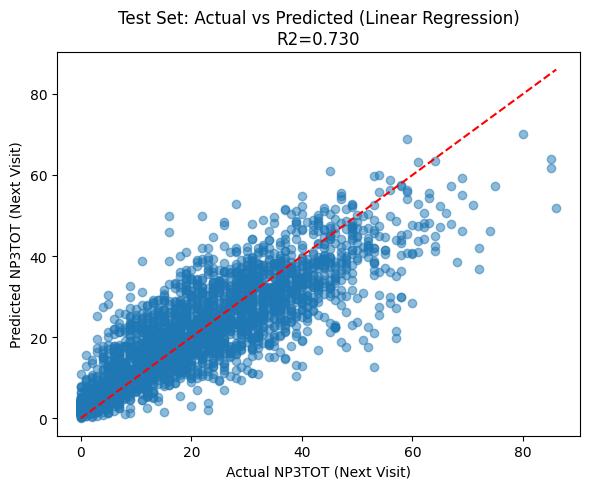

Training SVR...
SVR: MAE=5.921, RMSE=8.364, R2=0.702


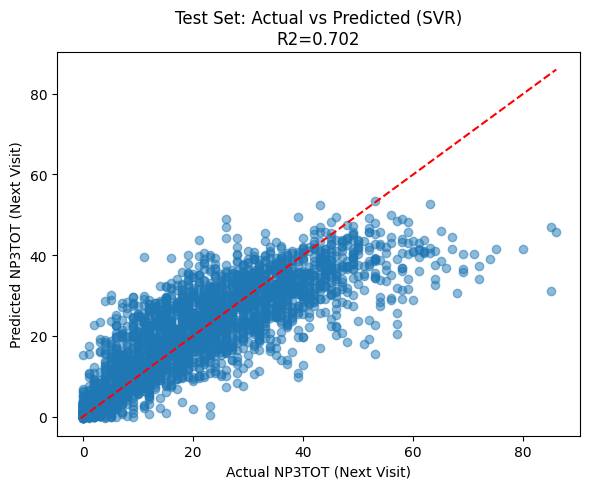

Training RandomForest Regressor...
RandomForest Regressor: MAE=5.861, RMSE=8.164, R2=0.716


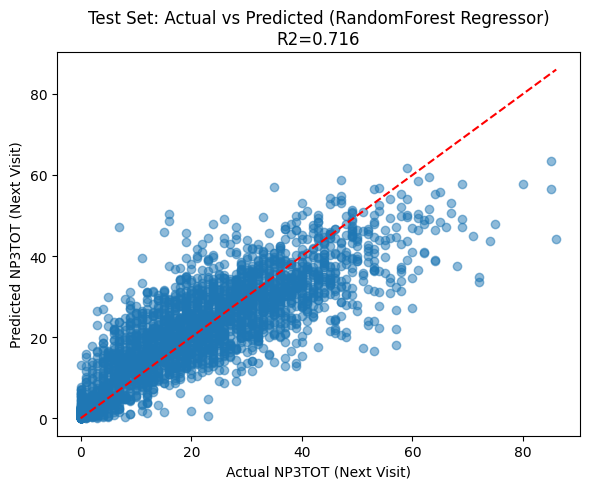

Training GradientBoosting Regressor...
GradientBoosting Regressor: MAE=5.818, RMSE=8.030, R2=0.725


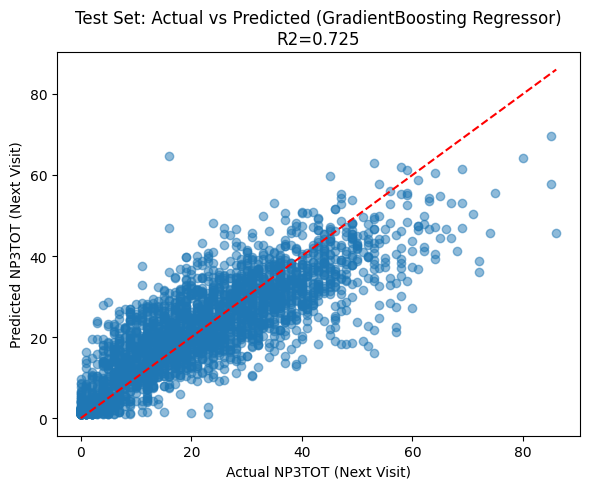

Training XGBoost...
XGBoost: MAE=5.988, RMSE=8.386, R2=0.700


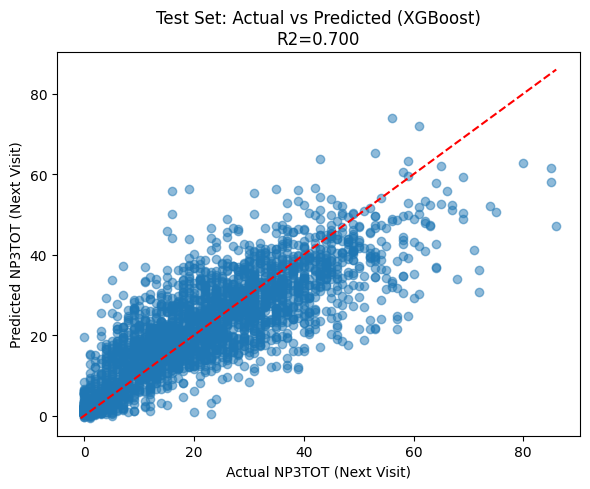

Training KNeighbors...
KNeighbors: MAE=6.514, RMSE=9.074, R2=0.649


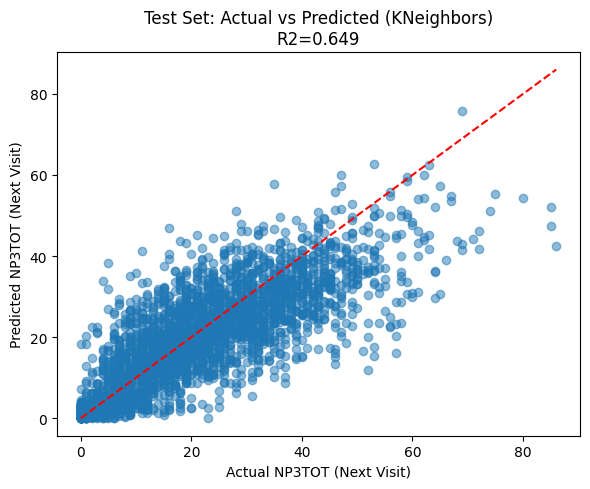

Training AdaBoostRegressor...
AdaBoostRegressor: MAE=9.673, RMSE=11.329, R2=0.453


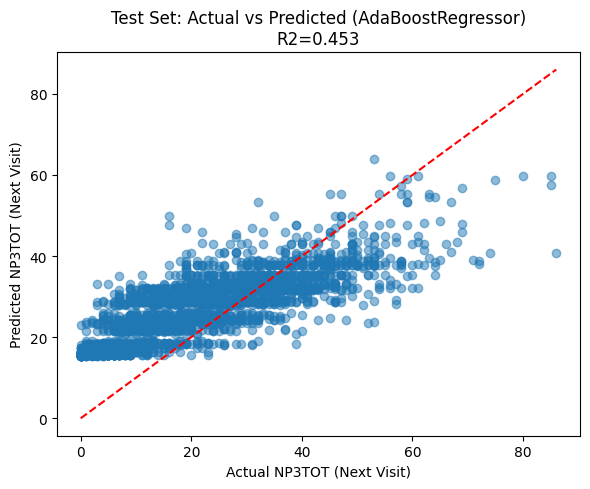

Training MLP Regressor...
MLP Regressor: MAE=5.882, RMSE=8.155, R2=0.716


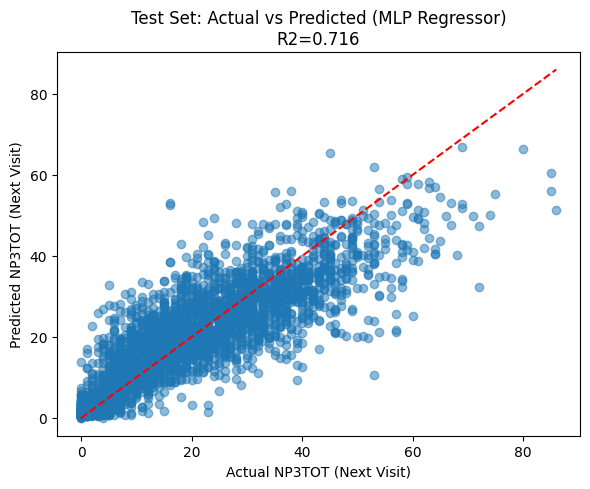


Test Set Performance Summary:
                        Model    MAE    RMSE  R-squared
0           Linear Regression  5.825   7.956      0.730
1                         SVR  5.921   8.364      0.702
2      RandomForest Regressor  5.861   8.164      0.716
3  GradientBoosting Regressor  5.818   8.030      0.725
4                     XGBoost  5.988   8.386      0.700
5                  KNeighbors  6.514   9.074      0.649
6           AdaBoostRegressor  9.673  11.329      0.453
7               MLP Regressor  5.882   8.155      0.716


In [ ]:
# ## 7. Model Training and Evaluation (Single Split)

# Define models to train (Added RandomForest)
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'),
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True)
}

# Initialize results list
results_test = []

print("\n--- Evaluating on Test Set ---")
# Train and evaluate each model on the single train/test split
for name, model in models.items():
    print(f"Training {name}...")
    # --- MODIFICATION START ---
    # Convert DataFrames to NumPy arrays for fitting and prediction
    # Ensure y_train and y_test are also Series/arrays (which they should be)
    model.fit(X_train_scaled.values, y_train) # Use .values
    y_pred = model.predict(X_test_scaled.values) # Use .values
    # --- MODIFICATION END ---

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results_test.append({"Model": name, "MAE": mae, "RMSE": rmse, "R-squared": r2})
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

    # Plot actual vs predicted for the test set
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"Test Set: Actual vs Predicted ({name})\nR2={r2:.3f}")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()

# Write test results to a CSV file
# csv_file_test = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test_lag3.csv"
# try:
#     with open(csv_file_test, mode='w', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
#         writer.writeheader()
#         writer.writerows(results_test)
#     print(f"\nTest set results written to {csv_file_test}")
# except IOError as e:
#     print(f"Error writing file {csv_file_test}: {e}")

# Display test results as DataFrame
results_test_df = pd.DataFrame(results_test)
print("\nTest Set Performance Summary:")
print(results_test_df.round(3))


--- Evaluating with Cross-Validation (on Training Data) ---
Cross-validating Linear Regression...
Linear Regression: MAE=5.877, RMSE=8.223, R2=0.722


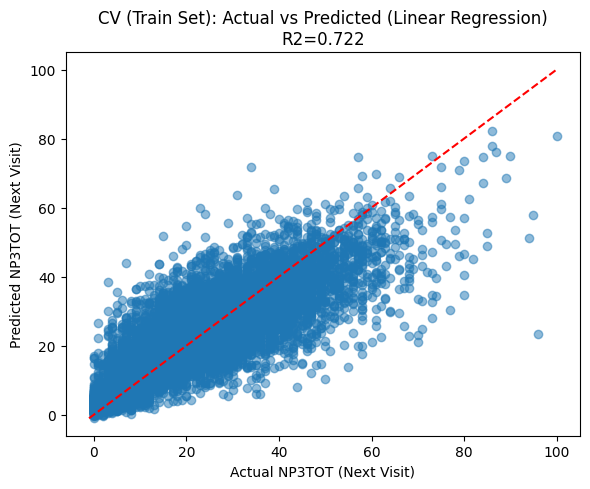

Cross-validating SVR...
SVR: MAE=5.962, RMSE=8.620, R2=0.695


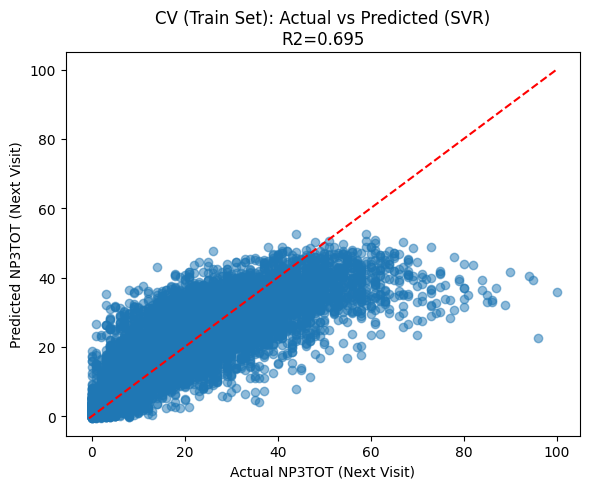

Cross-validating RandomForest Regressor...
RandomForest Regressor: MAE=5.861, RMSE=8.285, R2=0.718


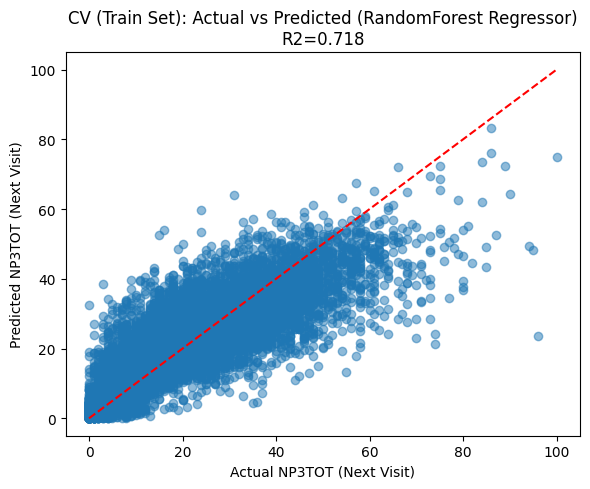

Cross-validating GradientBoosting Regressor...
GradientBoosting Regressor: MAE=5.817, RMSE=8.209, R2=0.723


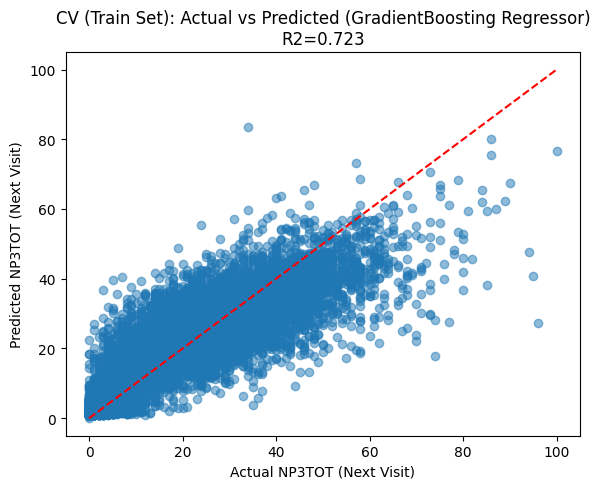

Cross-validating XGBoost...
XGBoost: MAE=6.094, RMSE=8.686, R2=0.690


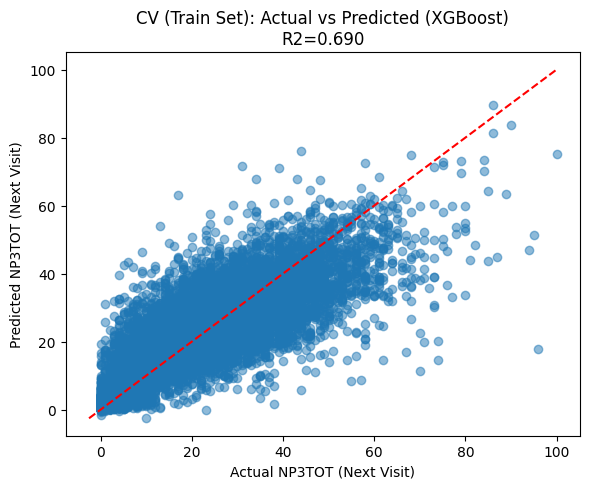

Cross-validating KNeighbors...
KNeighbors: MAE=6.425, RMSE=9.134, R2=0.658


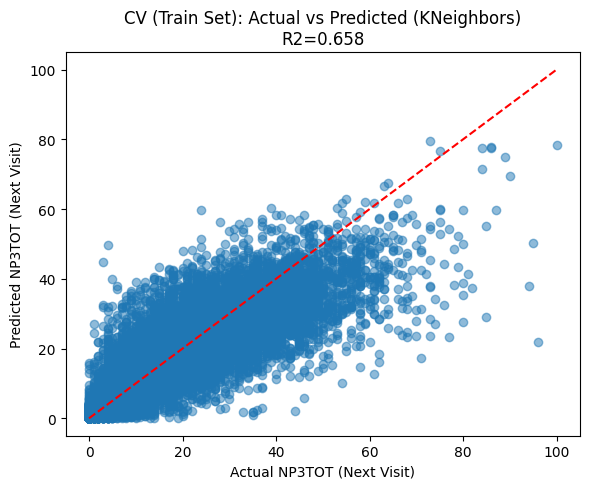

Cross-validating AdaBoostRegressor...
AdaBoostRegressor: MAE=9.392, RMSE=11.138, R2=0.491


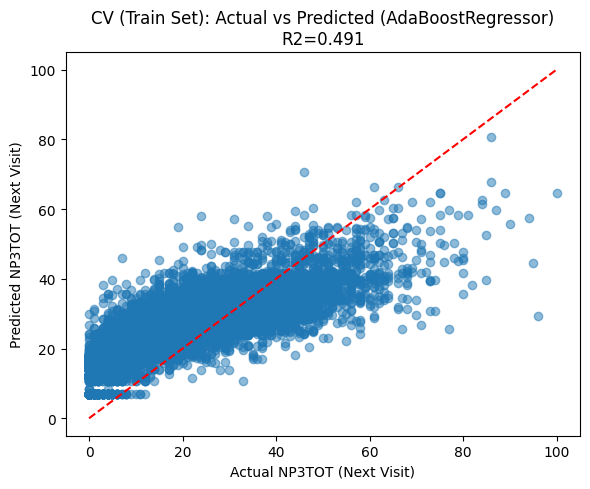

Cross-validating MLP Regressor...
MLP Regressor: MAE=5.966, RMSE=8.404, R2=0.710


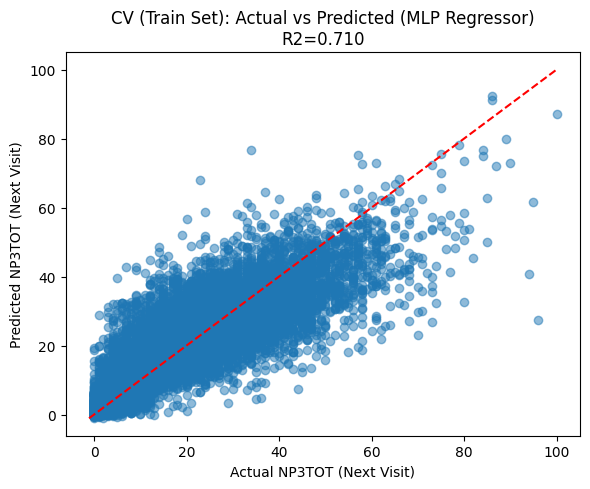


Cross-Validation Performance Summary (on Training Data):
                        Model    MAE    RMSE  R-squared
0           Linear Regression  5.877   8.223      0.722
1                         SVR  5.962   8.620      0.695
2      RandomForest Regressor  5.861   8.285      0.718
3  GradientBoosting Regressor  5.817   8.209      0.723
4                     XGBoost  6.094   8.686      0.690
5                  KNeighbors  6.425   9.134      0.658
6           AdaBoostRegressor  9.392  11.138      0.491
7               MLP Regressor  5.966   8.404      0.710


In [ ]:
# Initialize results list for CV
results_cv = []

# Define cross-validation strategy
cv = GroupKFold(n_splits=5) # Use GroupKFold


print("\n--- Evaluating with Cross-Validation (on Training Data) ---")

for name, model in models.items():
    print(f"Cross-validating {name}...")

    # --- MODIFICATION START ---
    # Get cross-validated predictions on the scaled training data (NumPy array)
    y_pred_cv = cross_val_predict(model, X_train_scaled.values, y_train, groups=groups_train, cv=cv) # Use .values
    # --- MODIFICATION END ---

    mae_cv = mean_absolute_error(y_train, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2_cv = r2_score(y_train, y_pred_cv)

    results_cv.append({"Model": name, "MAE": mae_cv, "RMSE": rmse_cv, "R-squared": r2_cv})
    print(f"{name}: MAE={mae_cv:.3f}, RMSE={rmse_cv:.3f}, R2={r2_cv:.3f}")

    # Plot actual vs predicted for CV
    plt.figure(figsize=(6, 5))
    plt.scatter(y_train, y_pred_cv, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"CV (Train Set): Actual vs Predicted ({name})\nR2={r2_cv:.3f}")
    min_val = min(y_train.min(), y_pred_cv.min())
    max_val = max(y_train.max(), y_pred_cv.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()


# Write CV results to a CSV file in the specified directory
# csv_file_cv = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test__cv_lag3.csv"
# try:
#     with open(csv_file_cv, mode='w', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
#         writer.writeheader()
#         writer.writerows(results_cv)
#     print(f"\nCross-validation results written to {csv_file_cv}")
# except IOError as e:
#     print(f"Error writing file {csv_file_cv}: {e}")

# Display CV results as DataFrame
results_cv_df = pd.DataFrame(results_cv)
print("\nCross-Validation Performance Summary (on Training Data):")
print(results_cv_df.round(3))